In [35]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from roboflow import Roboflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rf = Roboflow(api_key="d0TYZxZJCWWTuBFwxYNI")
project = rf.workspace("bangkit-academy-rnfpg").project("acne-detection-g5vvz")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [36]:
print(dataset.location)

c:\Users\yosua\Downloads\klasifikasi-jerawat\Acne-detection-1


In [37]:
import os
import shutil

# Deteksi lokasi folder dataset Roboflow secara dinamis
dataset_path = os.path.abspath("Acne-detection-1")
parent_dir = os.path.dirname(dataset_path)

# Buat folder baru untuk penggabungan di luar folder dataset
merged_path = os.path.join(parent_dir, "merged_acne_dataset")
os.makedirs(merged_path, exist_ok=True)

# Folder yang akan digabungkan (train, valid, test)
splits = ['train', 'valid', 'test']

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if not os.path.exists(split_path):
        continue

    # Iterasi semua folder kelas di dalam split
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Buat folder kelas di folder penggabungan jika belum ada
        merged_class_dir = os.path.join(merged_path, class_name)
        os.makedirs(merged_class_dir, exist_ok=True)

        # Salin semua gambar dari folder split ke folder gabungan
        for img_file in os.listdir(class_dir):
            src_file = os.path.join(class_dir, img_file)
            dst_file = os.path.join(merged_class_dir, img_file)

            # Hindari overwrite dengan penamaan unik
            if os.path.exists(dst_file):
                base, ext = os.path.splitext(img_file)
                counter = 1
                while True:
                    new_name = f"{base}_{counter}{ext}"
                    dst_file = os.path.join(merged_class_dir, new_name)
                    if not os.path.exists(dst_file):
                        break
                    counter += 1

            shutil.copy2(src_file, dst_file)

print(f"Dataset telah digabungkan ke dalam: {merged_path}")


Dataset telah digabungkan ke dalam: c:\Users\yosua\Downloads\klasifikasi-jerawat\merged_acne_dataset


In [38]:
acne_folder = os.path.join(merged_path, "Acne")

if os.path.isdir(acne_folder):
    shutil.rmtree(acne_folder)
    print("Folder 'Acne' telah dihapus")
else:
    print("Folder 'Acne' tidak ditemukan. Tidak ada yang perlu dihapus.")


Folder 'Acne' telah dihapus


In [ ]:
empty_folders = []

# Telusuri seluruh subfolder dalam merged_path
for root, dirs, files in os.walk(merged_path):
    for d in dirs:
        dir_path = os.path.join(root, d)
        # Cek apakah folder kosong
        if not os.listdir(dir_path):
            empty_folders.append(dir_path)

# Tampilkan hasilnya
if empty_folders:
    print("Folder kosong yang terdeteksi:")
    for folder in empty_folders:
        print("-", folder)
else:
    print("Tidak ada folder kosong.")


Tidak ada folder kosong di world line ini.


In [40]:
import os
import shutil
import random

# Path dataset hasil penggabungan
merged_path = os.path.abspath("merged_acne_dataset")
split_base = os.path.join(os.path.dirname(merged_path), "jerawat-split")

# Rasio pembagian
ratios = {
    'train': 0.80,
    'valid': 0.10,
    'test': 0.10
}

# Buat folder target: train, valid, test
for split in ratios:
    for class_name in os.listdir(merged_path):
        class_dir = os.path.join(split_base, split, class_name)
        os.makedirs(class_dir, exist_ok=True)

# Proses pembagian per kelas
for class_name in os.listdir(merged_path):
    class_path = os.path.join(merged_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Daftar file dalam kelas
    files = os.listdir(class_path)
    random.shuffle(files)

    total = len(files)
    train_end = int(total * ratios['train'])
    valid_end = train_end + int(total * ratios['valid'])

    split_files = {
        'train': files[:train_end],
        'valid': files[train_end:valid_end],
        'test': files[valid_end:]
    }

    # Salin file ke folder baru
    for split, file_list in split_files.items():
        for file_name in file_list:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(split_base, split, class_name, file_name)
            shutil.copy2(src_file, dst_file)

print(f"Dataset telah terpecah ke dalam folder baru: {split_base}")


Dataset telah terpecah ke dalam folder baru: c:\Users\yosua\Downloads\klasifikasi-jerawat\jerawat-split


In [ ]:
import os

split_base = os.path.abspath("jerawat-split")

train_dir = os.path.join(split_base, "train")
valid_dir = os.path.join(split_base, "valid")
test_dir  = os.path.join(split_base, "test")

print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")
print(f"Test directory:  {test_dir}")

Train directory: c:\Users\yosua\Downloads\klasifikasi-jerawat\jerawat-split\train
Valid directory: c:\Users\yosua\Downloads\klasifikasi-jerawat\jerawat-split\valid
Test directory:  c:\Users\yosua\Downloads\klasifikasi-jerawat\jerawat-split\test


In [42]:
img_width = 224
img_height = 224
image_size = (img_width, img_height)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
valid_gen = valid_datagen.flow_from_directory(valid_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir,  target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_gen.class_indices)
print("Kelas ditemukan:", train_gen.class_indices)
print("Jumlah kelas:", num_classes)

Found 28666 images belonging to 697 classes.
Found 7885 images belonging to 697 classes.
Found 10957 images belonging to 697 classes.
Kelas ditemukan: {'Acne Blackhead': 0, 'Acne Blackhead Crystanlline': 1, 'Acne Blackhead Crystanlline Papular': 2, 'Acne Blackhead Crystanlline Purulent': 3, 'Acne Blackhead Cystic': 4, 'Acne Blackhead Cystic Folliculitis': 5, 'Acne Blackhead Cystic Folliculitis Keloid Papular': 6, 'Acne Blackhead Cystic Folliculitis Milium Papular Purulent': 7, 'Acne Blackhead Cystic Folliculitis Papular Purulent': 8, 'Acne Blackhead Cystic Keloid Milium Papular': 9, 'Acne Blackhead Cystic Keloid Milium Papular Purulent': 10, 'Acne Blackhead Cystic Keloid Papular Purulent': 11, 'Acne Blackhead Cystic Keloid Purulent': 12, 'Acne Blackhead Cystic Milium': 13, 'Acne Blackhead Cystic Milium Papular': 14, 'Acne Blackhead Cystic Milium Papular Purulent': 15, 'Acne Blackhead Cystic Milium Purulent': 16, 'Acne Blackhead Cystic Papular': 17, 'Acne Blackhead Cystic Papular Purule

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,271,417 (12.48 MB)

 Trainable params: 2,874,873 (10.97 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model2.keras", monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(patience=5, factor=0.3, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1318s 1s/step - accuracy: 0.0931 - loss: 6.2053 - val_accuracy: 0.0563 - val_loss: 10.3498 - learning_rate: 0.0010
Epoch 2/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1214s 1s/step - accuracy: 0.1452 - loss: 4.8086 - val_accuracy: 0.0807 - val_loss: 8.7357 - learning_rate: 0.0010
Epoch 3/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1140s 1s/step - accuracy: 0.2232 - loss: 4.0760 - val_accuracy: 0.1031 - val_loss: 6.2650 - learning_rate: 0.0010
Epoch 4/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1137s 1s/step - accuracy: 0.3337 - loss: 3.4341 - val_accuracy: 0.1075 - val_loss: 6.5593 - learning_rate: 0.0010
Epoch 5/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1140s 1s/step - accuracy: 0.4509 - loss: 2.8866 - val_accuracy: 0.1705 - val_loss: 5.9014 - learning_rate: 0.0010
Epoch 6/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step - accuracy: 0.5507 - loss: 2.4549 - val_accuracy: 0.3469 - val_loss: 3.9603 - learning_rate: 0.0010
Epoch 7/50
896/896 ━━━━━━━━━━━━━━━━━━━━ 1101s 1s/step - accuracy: 0.6365 - 

In [45]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_gen)
y_true = test_gen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

343/343 ━━━━━━━━━━━━━━━━━━━━ 185s 532ms/step
                                                                                              precision    recall  f1-score   support

                                                                              Acne Blackhead       0.71      0.89      0.79        28
                                                                 Acne Blackhead Crystanlline       1.00      0.50      0.67         8
                                                         Acne Blackhead Crystanlline Papular       1.00      0.62      0.77         8
                                                        Acne Blackhead Crystanlline Purulent       0.60      1.00      0.75         6
                                                                       Acne Blackhead Cystic       1.00      0.20      0.33         5
                                                          Acne Blackhead Cystic Folliculitis       1.00      1.00      1.00         5
                

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [49]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'\n Akurasi Testing: {test_acc * 100:.2f}%')

343/343 ━━━━━━━━━━━━━━━━━━━━ 211s 614ms/step - accuracy: 0.9028 - loss: 0.9093

 Akurasi Testing: 91.48%


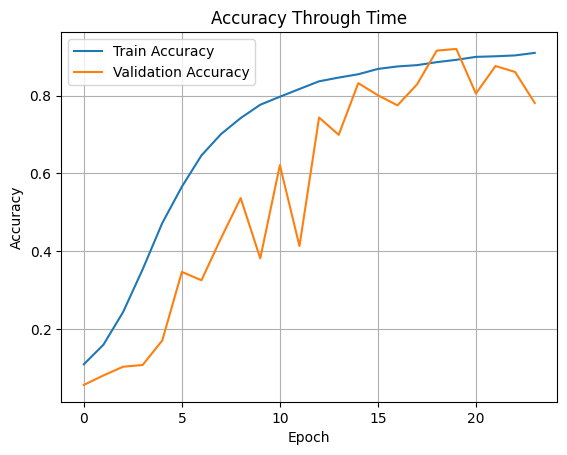

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
model.save("model_klasifikasi_jerawat2.h5")
print("Model tersimpan sebagai model_klasifikasi_jerawat.h5")


Model tersimpan sebagai model_klasifikasi_jerawat.h5
